Using device: cpu
Training samples: 60000
Test samples: 10000
Starting training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304586
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.277550
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.144986
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.128778
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.084715
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.047987
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.233712
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.059080
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.107047
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.217734
Train Epoch: 1 | Average Loss: 0.2033 | Accuracy: 93.76%
Test set: Average loss: 0.0441, Accuracy: 9860/10000 (98.60%)
🎯 Target accuracy of 95% reached at epoch 1!

Training completed!


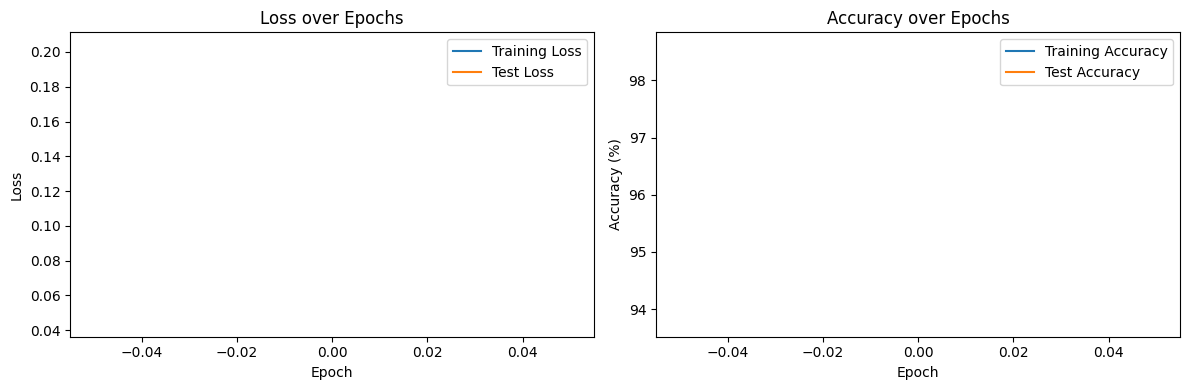


Visualizing predictions on 5 sample images:


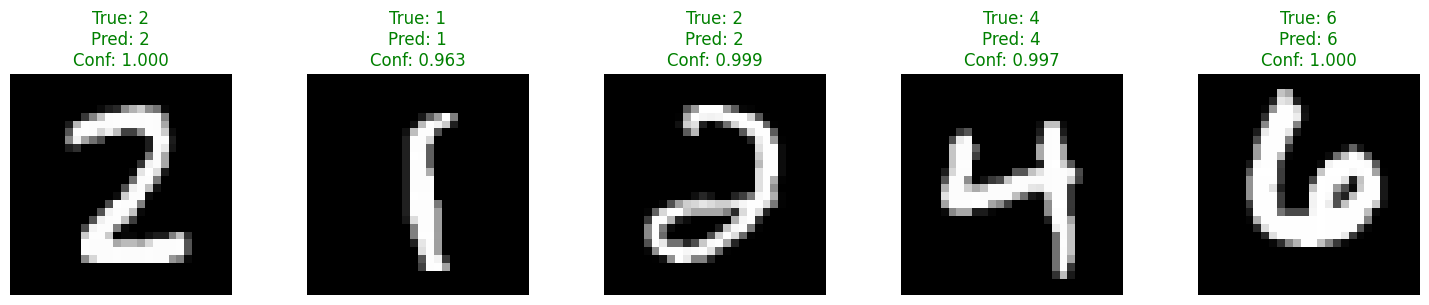


Final Evaluation:
Test set: Average loss: 0.0441, Accuracy: 9860/10000 (98.60%)
✅ SUCCESS: Model achieved 98.60% test accuracy (target: >95%)
Model saved as 'mnist_cnn_model.pth'

Model Architecture:
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Define CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # Corrected input features for the first fully connected layer
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        # Reshape to maintain the batch size dynamically
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x  # Return raw logits (CrossEntropyLoss applies softmax)

# Initialize model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    accuracy = 100. * correct / total
    avg_loss = train_loss / len(train_loader)
    print(f'Train Epoch: {epoch} | Average Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')
    return avg_loss, accuracy

# Training loop
print("Starting training...")
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

epochs = 10
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Early stopping if we reach target accuracy
    if test_acc >= 95.0:
        print(f"🎯 Target accuracy of 95% reached at epoch {epoch}!")
        break

print("\nTraining completed!")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

# Function to visualize predictions on sample images
def visualize_predictions(model, device, test_dataset, num_samples=5):
    model.eval()

    # Get random samples from test set
    indices = random.sample(range(len(test_dataset)), num_samples)

    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]

        # Add batch dimension and move to device
        image_batch = image.unsqueeze(0).to(device)

        # Get prediction
        with torch.no_grad():
            output = model(image_batch)
            pred_prob = F.softmax(output, dim=1)
            pred_label = output.argmax(dim=1).item()
            confidence = pred_prob[0][pred_label].item()

        # Plot
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')

        # Color code: green if correct, red if wrong
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                 color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on 5 sample images
print("\nVisualizing predictions on 5 sample images:")
visualize_predictions(model, device, test_dataset, num_samples=5)

# Final evaluation
print("\nFinal Evaluation:")
final_test_loss, final_accuracy = test(model, device, test_loader)

if final_accuracy >= 95.0:
    print(f"✅ SUCCESS: Model achieved {final_accuracy:.2f}% test accuracy (target: >95%)")
else:
    print(f"❌ Model achieved {final_accuracy:.2f}% test accuracy (target: >95%)")

# Save the model
torch.save(model.state_dict(), 'mnist_cnn_model.pth')
print("Model saved as 'mnist_cnn_model.pth'")

# Print model summary
print("\nModel Architecture:")
print(model)